In [1]:
# Run this cell and all subsequent cells as you encounter 
# them by pressing Control+Enter or Shift+Enter simultaneously

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from simplified_monorotor import Monorotor
import plotting
import testing
import trajectories

pylab.rcParams['figure.figsize'] = 10,10

## Monorotor Review
In this lesson, we will design a controller for a monorotor that moves only in the vertical direction.

We want to focus on controls concepts, so we will be hiding or ignoring some of the details from the last lesson. Most importantly:

1. **Ignoring yaw** - this will let us focus on $z$ motion.
2. **Ignoring propellers** - we will set the `thrust` property directly instead of worrying about the rotational rates that generate that thrust.

The `Monorotor` class we will be working with is shown below.

#### TODO - Read through `Monorotor` class.
You will be controlling this vehicle throughout this lesson so it's worth understanding how it works. Pay attention to the simplifications noted above.

In [2]:
class Monorotor:
    
    def __init__(self, m=1.0):
        self.m = m
        self.g = 9.81
        
        # note that we're no longer thinking of rotation rates.
        # We are thinking directly in terms of thrust.
        self.thrust = 0.0
        
        # (ivogeorg) state vector
        # z, z_dot
        self.X = np.array([0.0,0.0])
      
    @property
    def z(self): 
        return self.X[0]
    
    @property
    def z_dot(self):
        return self.X[1]
    
    @property
    def z_dot_dot(self): 
        f_net = self.m * self.g - self.thrust
        return f_net / self.m
    
    def advance_state(self, dt):
        # (ivogeorg) integration vector
        X_dot = np.array([
            self.z_dot, 
            self.z_dot_dot
        ])
        
        # (ivogeorg) X_dot * dt is the delta vector
        
        self.X = self.X + X_dot * dt
        return self.X

## Open loop controller

This code implements an "open loop controller" for a monorotor.

Notice that the controller **only** needs to know the mass of the vehicle and the initial state (assumed to be $z=0$ and $\dot{z}=0$). 

The `thrust_control` function is then called at each timestep. All that this function needs to know is where the drone should be (`target_z`) and when it needs to be there (`dt`)! _(ivogeorg) `dt` is not a point in time (that is, a "when") but rather an integration (or a discretized approximation of integration) variable. (ivogeorg-end)_

In theory, this should work... right?

#### TODO 1 - Review `OpenLoopController`
In particular, read through the `thrust_control` method to make sure you understand how it works. 

In [4]:
class OpenLoopController:
    
    def __init__(self, vehicle_mass, initial_state=np.array([0, 0])):  
        self.vehicle_mass  = vehicle_mass 
        
        # vehicle_state is the controller's BELIEF about the state
        # of the vehicle it is controlling. It doesn't know the 
        # TRUE state.
        self.vehicle_state = initial_state  # [z, z_dot]
        self.g = 9.81
    
    def thrust_control(self, target_z, dt):
        """
        Returns a thrust which will be commanded to 
        the vehicle. This thrust should cause the vehicle
        to be at target_z in dt seconds.
        
        The controller's internal model of the vehicle_state
        is also updated in this method.
        """
        # (ivogeorg)
        # The way dt is used here is ambiguous. Usually, it
        # is used to represent "instantaneous time", making
        # all the other variables calculated with it also
        # instantaneous. But then, statements like
        # target_z_dot = delta_z / dt, and
        # target_z_dot_dot = delta_z_dot / dt
        # are problematic.
        # (ivogeorg-end)
        
        # 1. find target velocity needed to get to target_z
        current_z, current_z_dot = self.vehicle_state
        delta_z = target_z - current_z
        target_z_dot = delta_z / dt
        
        # 2. find target acceleration needed
        delta_z_dot = target_z_dot - current_z_dot
        target_z_dot_dot = delta_z_dot / dt
        
        # 3. find target NET force
        target_f_net = target_z_dot_dot * self.vehicle_mass
        
        # 4. find target thrust. Recall this equation:
        #    F_net = mg - thrust
        thrust = self.vehicle_mass * self.g - target_f_net
        
        # 5. update controller's internal belief of state
        self.vehicle_state += np.array([delta_z, delta_z_dot])
        
        return thrust 


## Simulating Open Loop Control
We will try to follow the following trajectory for 5.0 seconds:

$$z(t) = 0.5\cos(2t)-0.5$$

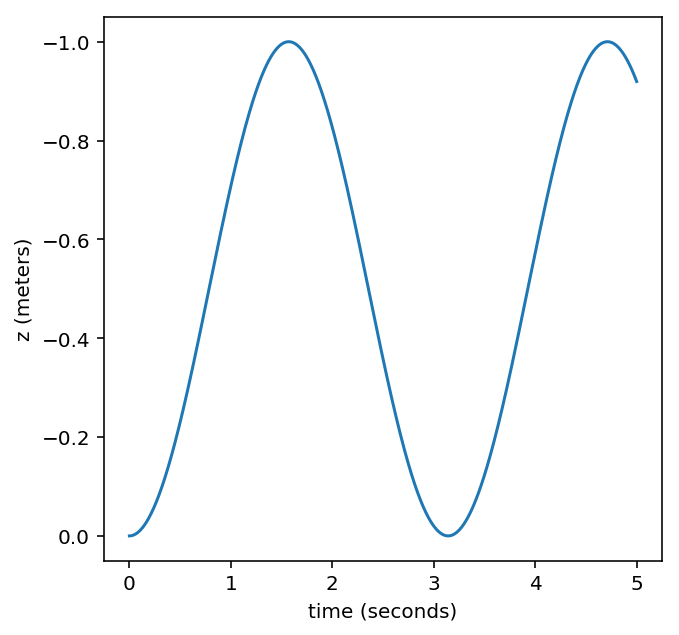

In [6]:
# generate and visualize the target trajectory

total_time = 5.0
t = np.linspace(0.0, total_time, 1000)
dt = t[1] - t[0]
# (ivogeorg)
# Obviously, dt is a time step, equal to 5.0 / 1000 here.
# In the limit, it is a differentiation or integration
# variable. Here, it is used more coarsely, but it still
# isn't a target trajectory time. It does commant 
# instantaneous thrust (which, of course, overshoots, not
# least because of dt being used as a target time).
# (ivogeorg-end)

z_path = 0.5 * np.cos(2 * t) - 0.5

plt.figure(figsize=(5, 5))
plt.ylabel("z (meters)")
plt.xlabel("time (seconds)")
plt.gca().invert_yaxis()
plt.plot(t, z_path)
plt.show()

#### TODO 2 - Read through simulation code
Read through sections 1 and 2 of the code below. 

In section 1, note how `perceived_mass` is calculated and used. 

In section 2, note how the simulation actually works:

1. The controller commands a `thrust` based on the `target_z`.
2. The drone's thrust is set to this value.

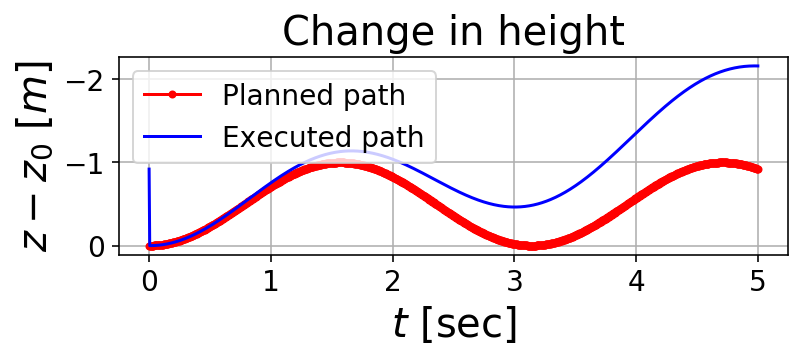

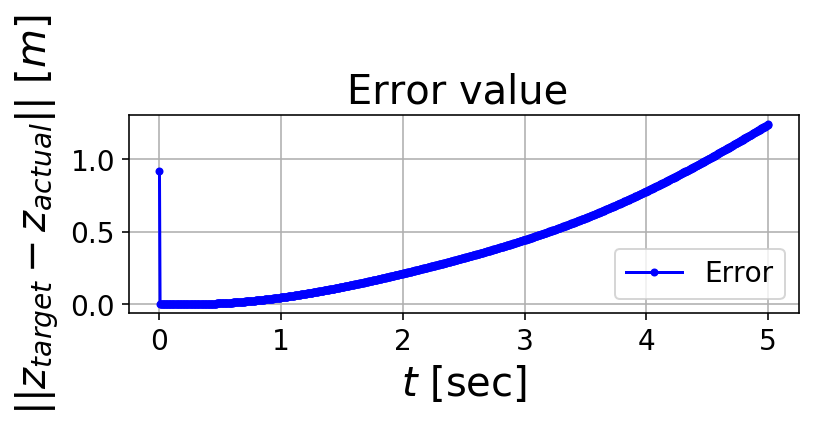

In [11]:
# 1. Preparation for simulation

MASS_ERROR = 1.01  # (ivogeorg) Observe behavior for e = {1.001, 1.01, 1.1}

# (ivogeorg)
# The estimate of z_dot_dot of the drone depends on the mass.
# The calculation of the target thrust in the controller
# also depends on the mass. The larger the mass error, the 
# less accurate the estimate it, and, correspondingly, the 
# larger the correction thrust, and, in turn, the larger the 
# overshoot. The mass error results in an error in z_dot_dot
# epsilon, which gives the position z by double integration.
# Thus, if 'overshoot' is defined in terms of the difference
# in target position z(t)-z_0, then it is proportional to
# the square of time tau, with coefficient of proportionality
# the error of mass epsilon. Or z(t)-z_0=0.5*epsilon*tau^2.
# (ivogeorg-end)

drone = Monorotor()
drone_start_state = drone.X
drone_mass = drone.m

# The mass that the controller believes is not necessarily the
# true mass of the drone. This reflects the real world more accurately.
perceived_mass = drone_mass * MASS_ERROR
controller = OpenLoopController(perceived_mass, drone_start_state)

# 2. Run the simulation
drone_state_history = []
for target_z in z_path:
    drone_state_history.append(drone.X)
    thrust = controller.thrust_control(target_z, dt)
    drone.thrust = thrust
    drone.advance_state(dt)

# 3. Generate plots
z_actual = [h[0] for h in drone_state_history] 
plotting.compare_planned_to_actual(z_actual, z_path, t)

#### TODO 2 - Modify `MASS_ERROR`
Play around with different values for this parameter. Try 1.0, 1.01, etc... 

Note the effect this has on the resulting trajectory! 

What does this tell you about the feasibility of "open loop" control?